ATM, T=21


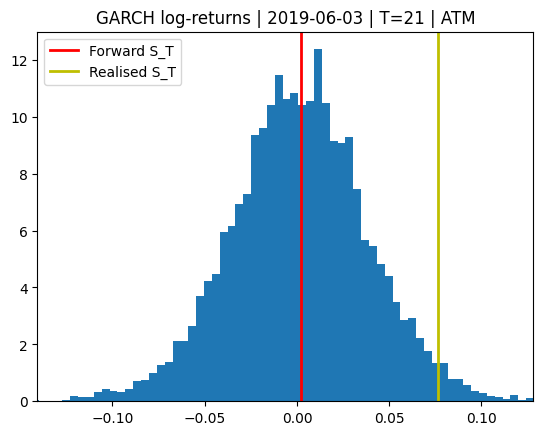

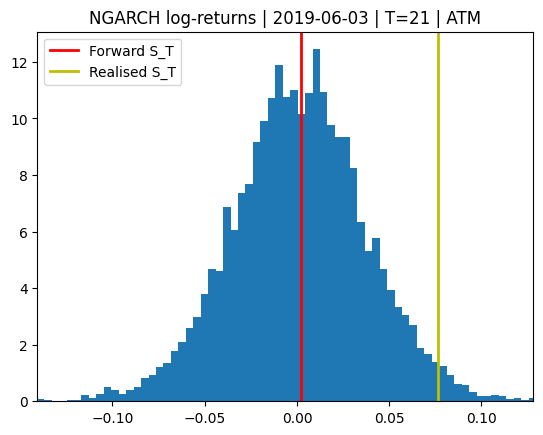

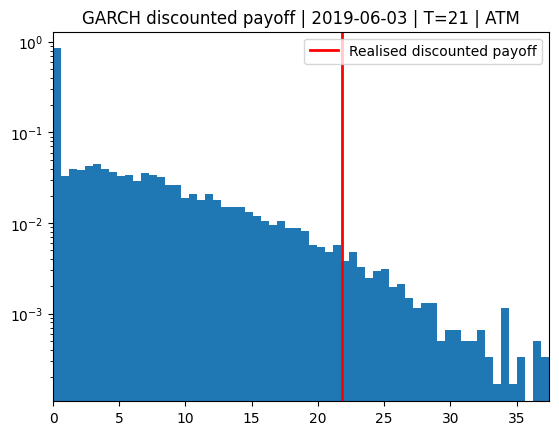

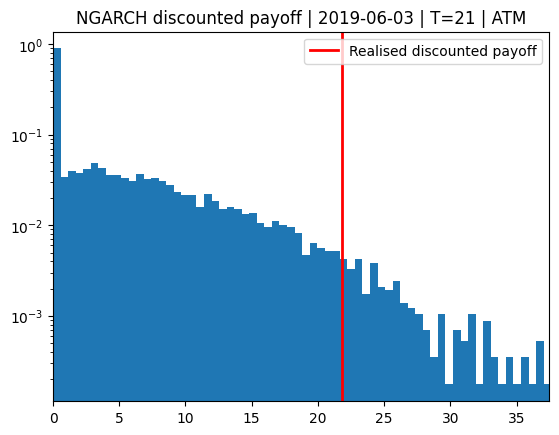

GARCH martingale ratio: 1.000140685242256
NGARCH martingale ratio: 0.9998354457098904
          n  optim_success_rate  bias_mean_error       mae      rmse  \
GARCH   175                 1.0        -1.068212  5.684483  8.141858   
NGARCH  175                 1.0        -1.148959  5.701563  8.188829   

        median_error  
GARCH       0.433101  
NGARCH      0.333962  


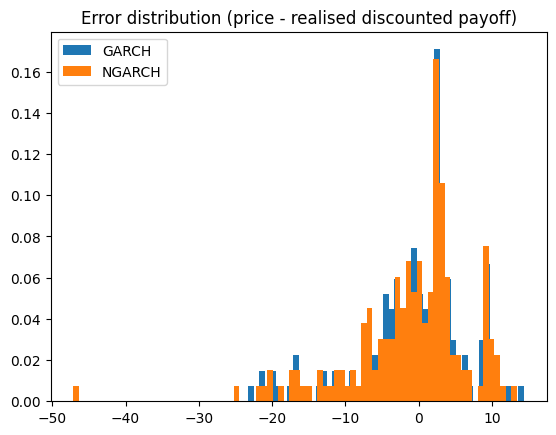

OTM, T=126


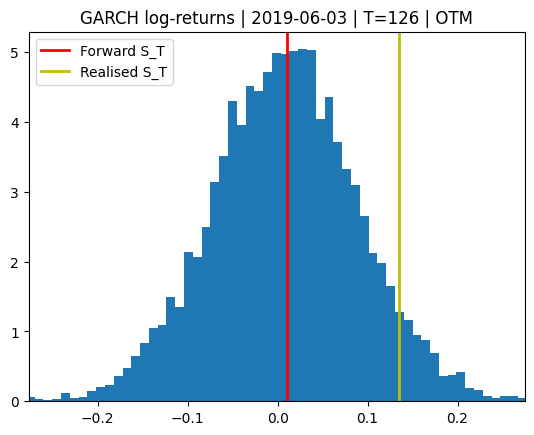

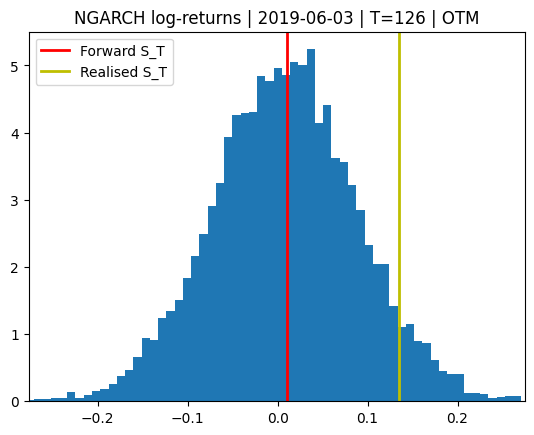

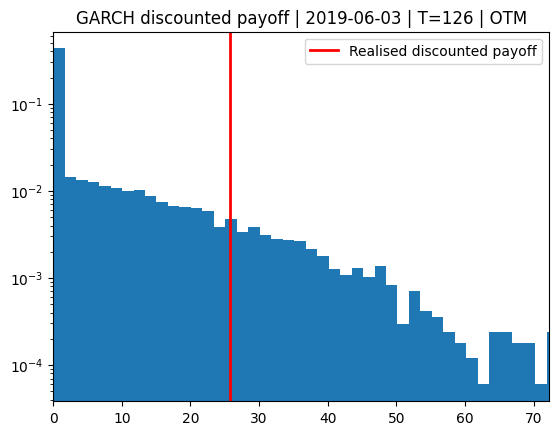

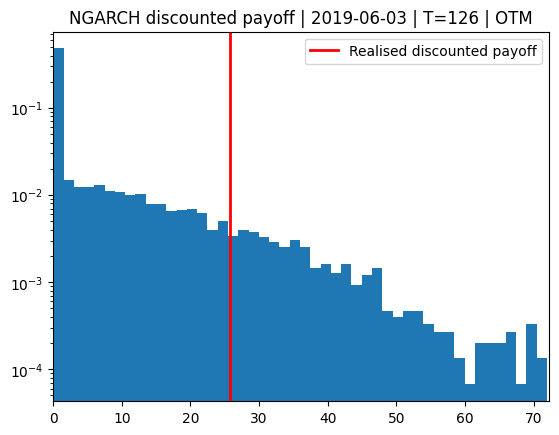

GARCH martingale ratio: 0.995700236145096
NGARCH martingale ratio: 1.000716963795362
          n  optim_success_rate  bias_mean_error        mae       rmse  \
GARCH   170                 1.0        -3.936727  11.220356  17.229520   
NGARCH  170                 1.0        -4.226193  11.262245  17.405997   

        median_error  
GARCH       1.070216  
NGARCH      0.749222  


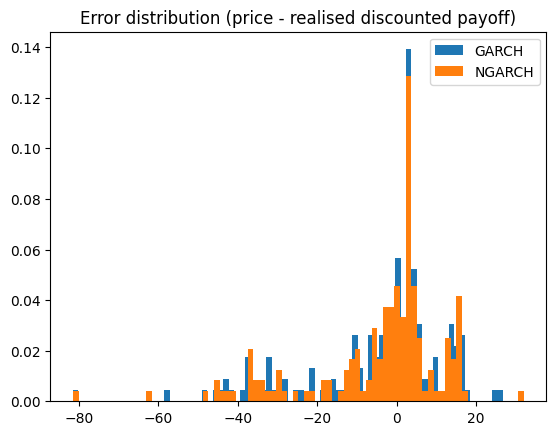

ATM, T=21


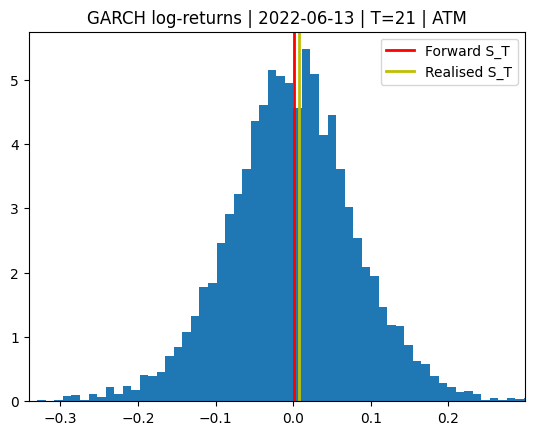

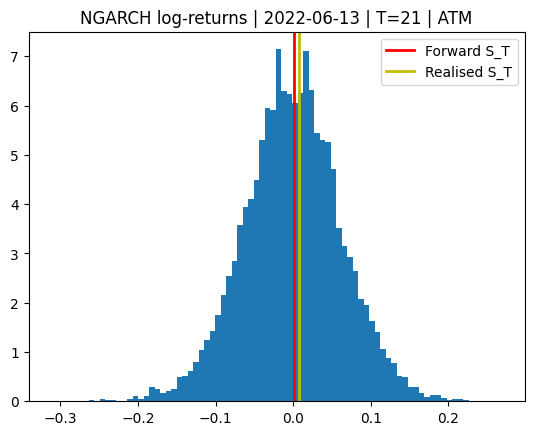

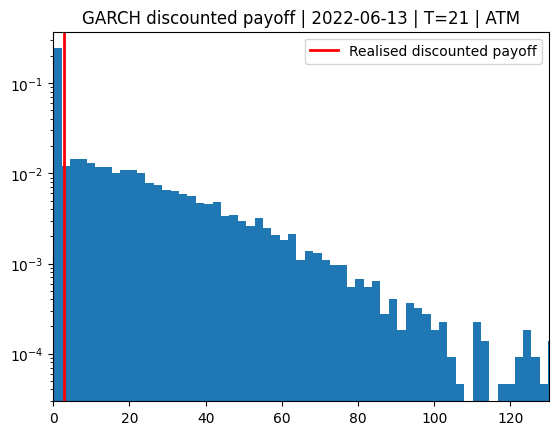

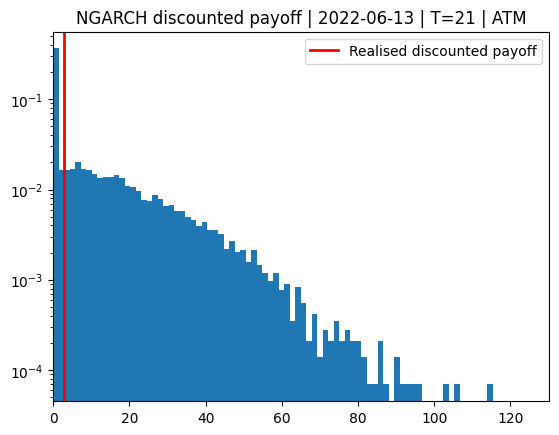

GARCH martingale ratio: 1.0006479570179414
NGARCH martingale ratio: 0.9999257958332578
          n  optim_success_rate  bias_mean_error       mae      rmse  \
GARCH   175                 1.0        -1.068212  5.684483  8.141858   
NGARCH  175                 1.0        -1.148959  5.701563  8.188829   

        median_error  
GARCH       0.433101  
NGARCH      0.333962  


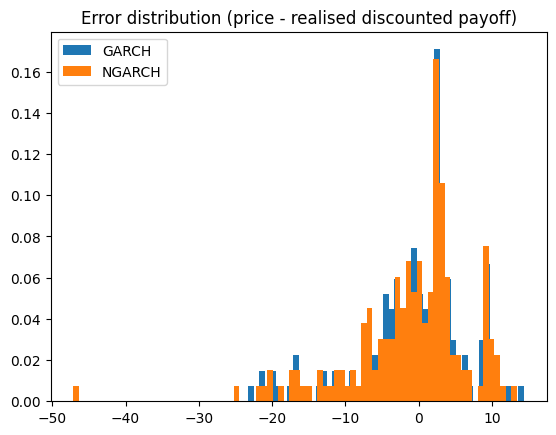

OTM, T=126


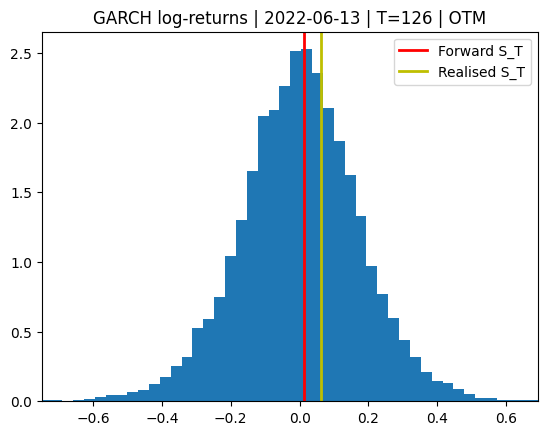

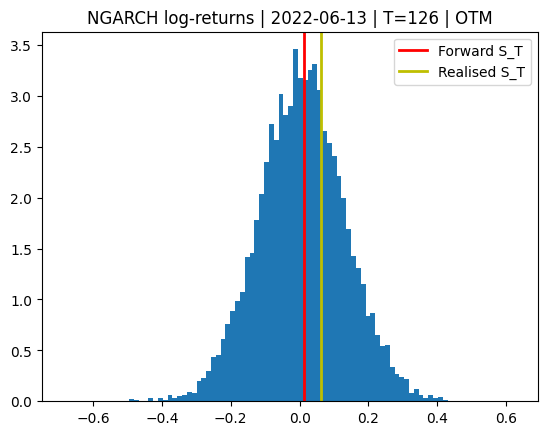

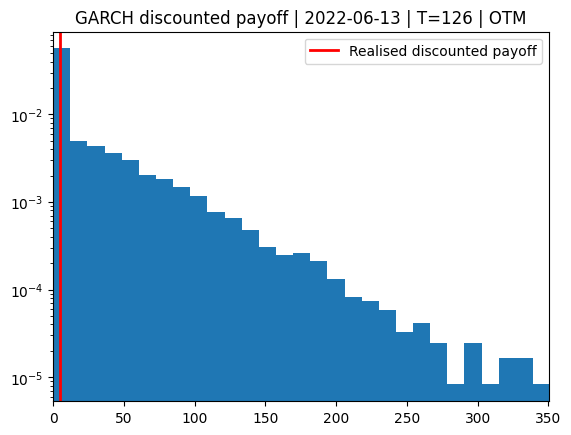

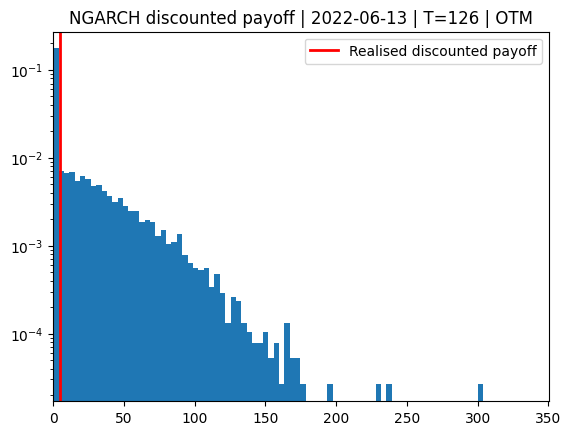

GARCH martingale ratio: 0.9937341612176909
NGARCH martingale ratio: 1.0017715056832606
          n  optim_success_rate  bias_mean_error        mae       rmse  \
GARCH   170                 1.0        -3.936727  11.220356  17.229520   
NGARCH  170                 1.0        -4.226193  11.262245  17.405997   

        median_error  
GARCH       1.070216  
NGARCH      0.749222  


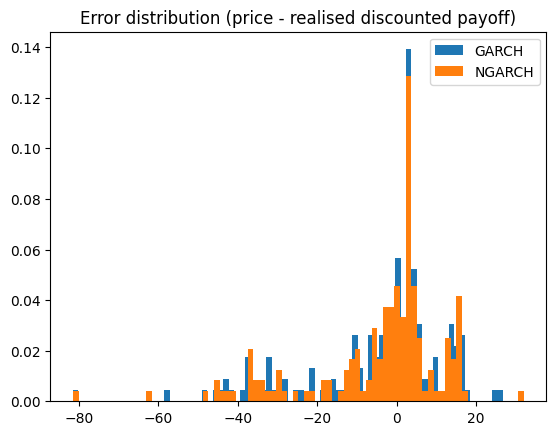

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from fredapi import Fred
from scipy.optimize import minimize

def get_financial_data(ticker, start_date, end_date):
    '''
    Creates a data frame with:
     - Downloaded close price data
     - Calculated log returns
     - Annualised risk free rate 
     for a given time window and ticker
    '''
    data = yf.download(
        ticker,
        start_date,
        end_date,
        auto_adjust=False,
        progress=False,
        threads=False
    )

    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    
    s_t = data['Close']
    log_ret = np.log(s_t/s_t.shift(1))

    fred = Fred(api_key="55852d4f1c997c4d83aeb2c1f18e4482")

    sofr = fred.get_series("SOFR") / 100.0
    
    dgs3mo = fred.get_series("DGS3MO") / 100.0

    rf_annual = sofr.combine_first(dgs3mo)

    rf_annual = rf_annual.reindex(s_t.index).ffill()

    rf_daily = rf_annual / 252

    df = pd.concat([s_t.rename('S_t'), log_ret.rename('Log Returns'), rf_daily.rename('Risk-Free Rate')], axis=1).dropna()

    return df

def garch_manual(params, log_ret):
    ''' Architecture of garch, producing the ll which is minimised during fitting'''
    mu, omega, alpha, beta = params

    if omega <= 0 or alpha < 0 or beta < 0 or (alpha + beta) >= 0.99:
        return 1e12
    
    T = len(log_ret)
    epsilon = log_ret - mu

    h = np.empty(T)
    h[0] = omega/(1 - alpha - beta)

    h_bound = 1e-12
    if h[0] <= h_bound or not np.isfinite(h[0]):
        return 1e12

    ll = 0.0
    for t in range (1, T):
        h[t] = omega + alpha * epsilon[t-1]**2 + beta * h[t-1]

        if h[t] <= h_bound or not np.isfinite(h[t]):
            return 1e12

        ll += 0.5 * (np.log(h[t]) + epsilon[t]**2 / h[t])
    
    return ll

def garch_fitting(df):
    '''Minimises ll for given data to fit garch parameters'''
    log_ret = df['Log Returns'].to_numpy()

    mu0 = np.mean(log_ret)
    var0 = np.var(log_ret)

    alpha0, beta0 = 0.05, 0.90
    omega0 = var0 * (1 - alpha0 - beta0)

    log_ret0  = np.array([mu0, omega0, alpha0, beta0])

    bounds = [
        (None, None),
        (1e-12, None),
        (0.0, 1.0),
        (0.0, 1.0),
    ]

    res = minimize(
        garch_manual,
        x0=log_ret0,
        args=(log_ret,),
        method="L-BFGS-B",
        bounds=bounds
    )

    return res

def garch_filter(params, log_ret):
    ''' '''
    mu, omega, alpha, beta = params
    epsilon = log_ret - mu
    T = len(epsilon)

    h = np.empty(T)
    h[0] = omega / (1.0 - alpha - beta)

    h_bound = 1e-12
    if h[0] <= h_bound or not np.isfinite(h[0]):
        raise ValueError("Invalid initial h[0]. Check parameters.")

    for t in range(1, T):
        h[t] = omega + alpha * epsilon[t-1]**2 + beta * h[t-1]
        if h[t] <= h_bound or not np.isfinite(h[t]):
            raise ValueError(f"Invalid h at t={t}. Check parameters/data.")

    return h, epsilon

def garch_mc_price(
        S0,
        K,
        T_days,
        rf_daily,
        omega,
        alpha,
        beta,
        h0,
        n_paths=50000,
        lambda_q=0.0,
        seed=123,
    ):
    rng = np.random.default_rng(seed)

    if np.isscalar(rf_daily):
        r_path = np.full(T_days, float(rf_daily))
    else:
        r_path = np.asarray(rf_daily, dtype=float)
        if r_path.shape[0] != T_days:
            raise ValueError("If rf_daily is an array, it must have length T_days.")

    S = np.full(n_paths, S0, dtype=float)
    h = np.full(n_paths, h0, dtype=float)

    disc = np.exp(-np.sum(r_path))

    for t in range(T_days):
        z = rng.standard_normal(n_paths)

        h = omega + alpha * h * (z - lambda_q)**2 + beta * h
        h = np.maximum(h, 1e-12)
        
        S = S * np.exp(r_path[t] - 0.5 * h + np.sqrt(h) * z)

    payoff = np.maximum(S - K, 0.0)
    price = disc * payoff.mean()
    standard_error = disc * payoff.std(ddof=1) / np.sqrt(n_paths)

    return price, standard_error

def price_at_date_garch(
        df,
        pricing_date,
        lookback_window=504,
        T_days=21,
        n_paths=50000,
        lambda_q=0.0,
        call_type='ATM'
    ):
    if pricing_date not in df.index:
        raise ValueError("Pricing date not in index")
    
    t_idx = df.index.get_loc(pricing_date)
    if t_idx < lookback_window:
        raise ValueError("Not enough historical data for chosen lookback_window")
    if t_idx + T_days >= len(df):
        raise ValueError("Not enough future data for chosen maturity")
    
    w = df.iloc[t_idx - lookback_window : t_idx + 1]
    x = w["Log Returns"].to_numpy()

    res = garch_fitting(w)
    mu_hat, omega_hat, alpha_hat, beta_hat = res.x

    h_path, _ = garch_filter(res.x, x)
    h0 = h_path[-1]

    S0 = df["S_t"].iloc[t_idx]

    if call_type == 'ATM':
        K = S0
    elif call_type == 'OTM':
        K = 1.05 * S0
    else:
        raise ValueError("Call type must be 'ATM' or 'OTM'")

    r_path = df["Risk-Free Rate"].iloc[t_idx + 1 : t_idx + 1 + T_days].to_numpy()

    price, standard_error = garch_mc_price(
        S0, 
        K,
        T_days, 
        r_path, 
        omega_hat,
        alpha_hat,
        beta_hat,
        h0,
        n_paths,
        lambda_q,
    )

    ST = df["S_t"].iloc[t_idx + T_days]
    realised = np.exp(-r_path.sum()) * max(ST - K, 0.0)

    return {
        "pricing_date": pricing_date,
        "S0": S0,
        "K": K,
        "T_days": T_days,
        "params": res.x,
        "h0": h0,
        "price": price,
        "mc_standard_error": standard_error,
        "realised_disc_payoff": realised,
        "error": price - realised,
        "optim_success": res.success,
        "optim_message": res.message
    }

def martingale_test_garch(
    S0,
    T_days,
    rf_daily,
    omega,
    alpha,
    beta,
    h0,
    n_paths=50000,
    lambda_q=0.0,
    seed=123
    ):
    rng = np.random.default_rng(seed)

    if np.isscalar(rf_daily):
        r_path = np.full(T_days, float(rf_daily))
    else:
        r_path = np.asarray(rf_daily, dtype=float)

    S = np.full(n_paths, S0, dtype=float)
    h = np.full(n_paths, h0, dtype=float)

    for t in range(T_days):
        z = rng.standard_normal(n_paths)
        h = omega + alpha * h * (z - lambda_q)**2 + beta * h
        h = np.maximum(h, 1e-12)
        S = S * np.exp(r_path[t] - 0.5 * h + np.sqrt(h) * z)

    martingale_ratio = S.mean() / (S0 * np.exp(r_path.sum()))

    return martingale_ratio

def rolling_backtest_garch(
        df,
        lookback_window=504,
        T_days=21,
        step=5,
        n_paths=50000,
        lambda_q=0.0,
        call_type='ATM'
    ):
    rows = []
    for t_idx in range(lookback_window, len(df) - T_days, step):
        pricing_date = df.index[t_idx]

        out = price_at_date_garch(
            df,
            pricing_date,
            lookback_window,
            T_days,
            n_paths,
            lambda_q,
            call_type
         )
        rows.append({
            "date": pricing_date,
            "price": out["price"],
            "mc_standard_error": out["mc_standard_error"],
            "realised_disc_payoff": out["realised_disc_payoff"],
            "error": out["error"],
            "mu": out["params"][0],
            "omega": out["params"][1],
            "alpha": out["params"][2],
            "beta": out["params"][3],
            "h0": out["h0"],
            "optim_success": out["optim_success"]
        })

    return pd.DataFrame(rows).set_index("date")

def simulate_terminal_ST_garch(
        S0,
        T_days,
        r_path,
        omega,
        alpha,
        beta,
        h0,
        n_paths=50000,
        lambda_q=0.0,
        seed=123
    ):
    rng = np.random.default_rng(seed)
    r_path = np.asarray(r_path, dtype=float)
    if r_path.shape[0] != T_days:
        raise ValueError("r_path must have length T_days")

    S = np.full(n_paths, S0, dtype=float)
    h = np.full(n_paths, h0, dtype=float)

    for t in range(T_days):
        z = rng.standard_normal(n_paths)
        h = omega + alpha * h * (z - lambda_q)**2 + beta * h
        h = np.maximum(h, 1e-12)
        S = S * np.exp(r_path[t] - 0.5 * h + np.sqrt(h) * z)

    return S

def common_logret_limits(ST_g, ST_n, S0, q_low=0.001, q_high=0.999):
    log_g = np.log(ST_g / S0)
    log_n = np.log(ST_n / S0)

    lo = min(np.quantile(log_g, q_low), np.quantile(log_n, q_low))
    hi = max(np.quantile(log_g, q_high), np.quantile(log_n, q_high))

    return lo, hi

def common_payoff_limits(pay_g, pay_n, q_high=0.999):
    hi = max(np.quantile(pay_g, q_high), np.quantile(pay_n, q_high))
    return (0.0, hi)


def plot_log_ret_distribution(
        ST_distribution,
        S0,
        r_path,
        ST_realised,
        title="Terminal Log Returns Distribution",
        xlim=None,
        ylim=None
    ):

    log_forward = np.sum(r_path) 

    plt.figure()
    plt.hist(np.log(ST_distribution / S0), bins=80, density=True)
    plt.axvline(log_forward, linewidth=2, label="Forward S_T", color='r')
    plt.axvline(np.log(ST_realised / S0), linewidth=2, label="Realised S_T",color='y')

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.title(title)
    plt.legend()
    plt.show()

def plot_payoff_distribution(
        ST_distribution,
        K,
        r_path,
        ST_realised,
        title="Discounted Payoff Distribution",
        xlim=None,
        ylim=None,
        logy=True
    ):

    disc = np.exp(-np.sum(r_path))
    payoff_sim = disc * np.maximum(ST_distribution - K, 0.0)
    payoff_realised = disc * max(ST_realised - K, 0.0)

    plt.figure()
    plt.hist(payoff_sim, bins=80, density=True)
    plt.axvline(payoff_realised, linewidth=2, label="Realised discounted payoff", color = "r")

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if logy:
        plt.yscale("log")

    plt.title(title)
    plt.legend()
    plt.show()

def diagnostics_one_date_garch(
        df,
        pricing_date,
        lookback_window=504,
        T_days=21,
        n_paths=50000, 
        lambda_q=0.0,
        call_type='ATM'
    ):
    if pricing_date not in df.index:
        raise ValueError("pricing_date not in df index")
    t_idx = df.index.get_loc(pricing_date)

    if t_idx < lookback_window or t_idx + T_days >= len(df):
        raise ValueError("Insufficient history/future for chosen lookback_window/T_days")

    w = df.iloc[t_idx - lookback_window : t_idx + 1]
    x = w["Log Returns"].to_numpy()

    res = garch_fitting(w)
    mu_hat, omega_hat, alpha_hat, beta_hat = res.x

    h_path, _ = garch_filter(res.x, x)
    h0 = h_path[-1]

    S0 = df["S_t"].iloc[t_idx]

    if call_type == 'ATM':
        K = S0
    elif call_type == 'OTM':
        K = 1.05 * S0
    else:
        raise ValueError("Call type must be 'ATM' or 'OTM'")
    
    r_path = df["Risk-Free Rate"].iloc[t_idx + 1 : t_idx + 1 + T_days].to_numpy()
    ST_realised = df["S_t"].iloc[t_idx + T_days]

    ST_distribution = simulate_terminal_ST_garch(
        S0,
        T_days,
        r_path,
        omega_hat,
        alpha_hat,
        beta_hat,
        h0,
        n_paths,
        lambda_q,

    )

    plot_log_ret_distribution(ST_distribution, S0, r_path, ST_realised, title=f"GARCH Log Returns Distribution | {pricing_date}")
    plot_payoff_distribution(ST_distribution, K, r_path, ST_realised, title=f"GARCH Discounted Payoff | {pricing_date}")

    return {
        "params": res.x,
        "h0": h0,
        "optim_success": res.success,
        "optim_message": res.message
    }

def ngarch_manual(params, log_ret):
    mu, omega, alpha, beta, theta = params

    if omega <= 0 or alpha < 0 or beta < 0 or (alpha + beta) >= 0.99:
        return 1e12
    
    T = len(log_ret)
    epsilon = log_ret - mu

    h = np.empty(T)
    h[0] = np.var(epsilon)

    h_bound = 1e-12
    if h[0] <= h_bound or not np.isfinite(h[0]):
        return 1e12

    nll = 0.0
    for t in range (1, T):
        z_previous = epsilon[t-1] / np.sqrt(h[t-1])

        h[t] = omega + beta * h[t-1] + alpha * h[t-1] * (z_previous - theta)**2

        if h[t] <= h_bound or not np.isfinite(h[t]):
            return 1e12

        nll += 0.5 * (np.log(h[t]) + epsilon[t]**2 / h[t])
    
    return nll
    
def ngarch_fitting(df):
    log_ret = df['Log Returns'].to_numpy()

    mu0 = np.mean(log_ret)
    var0 = np.var(log_ret)

    alpha0, beta0 = 0.05, 0.90
    omega0 = var0 * (1 - alpha0 - beta0)
    theta0 = 0.0

    log_ret0  = np.array([mu0, omega0, alpha0, beta0, theta0])

    bounds = [
        (None, None),
        (1e-12, None),
        (0.0, 1.0),
        (0.0, 1.0),
        (-5, 5)
    ]

    res = minimize(
        ngarch_manual,
        x0=log_ret0,
        args=(log_ret,),
        method="L-BFGS-B",
        bounds=bounds
    )

    return res

def ngarch_filter(params, log_ret):
    mu, omega, alpha, beta, theta = params
    epsilon = log_ret - mu
    T = len(epsilon)

    h = np.empty(T)
    h[0] = np.var(epsilon)

    h_bound = 1e-12
    if h[0] <= h_bound or not np.isfinite(h[0]):
        raise ValueError("Invalid initial h[0]. Check parameters.")

    for t in range(1, T):
        z_previous = epsilon[t-1] / np.sqrt(h[t-1])

        h[t] = omega + beta * h[t-1] + alpha * h[t-1] * (z_previous - theta)**2

        if h[t] <= h_bound or not np.isfinite(h[t]):
            raise ValueError(f"Invalid h at t={t}. Check parameters/data.")

    z = epsilon / np.sqrt(h)

    return h, epsilon, z

def ngarch_mc_price(
        S0,
        K,
        T_days,
        rf_daily,
        omega,
        alpha,
        beta,
        theta,
        h0,
        n_paths=50000,
        lambda_q=0.0,
        seed=123,
    ):
    rng = np.random.default_rng(seed)

    if np.isscalar(rf_daily):
        r_path = np.full(T_days, float(rf_daily))
    else:
        r_path = np.asarray(rf_daily, dtype=float)
        if r_path.shape[0] != T_days:
            raise ValueError("If rf_daily is an array, it must have length T_days.")

    S = np.full(n_paths, S0, dtype=float)
    h = np.full(n_paths, h0, dtype=float)

    disc = np.exp(-np.sum(r_path))

    for t in range(T_days):
        z = rng.standard_normal(n_paths)

        h = omega + beta * h + alpha * h * (z - theta - lambda_q)**2
        h = np.maximum(h, 1e-12)
        
        S = S * np.exp(r_path[t] - 0.5 * h + np.sqrt(h) * z)

    payoff = np.maximum(S - K, 0.0)
    price = disc * payoff.mean()
    standard_error = disc * payoff.std(ddof=1) / np.sqrt(n_paths)

    return price, standard_error

def price_at_date_ngarch(
        df,
        pricing_date,
        lookback_window=504,
        T_days=21,
        n_paths=50000,
        lambda_q=0.0,
        call_type='ATM'
    ):
    if pricing_date not in df.index:
        raise ValueError("Pricing date not in index")
    
    t_idx = df.index.get_loc(pricing_date)
    if t_idx < lookback_window:
        raise ValueError("Not enough historical data for chosen lookback window")
    if t_idx + T_days >= len(df):
        raise ValueError("Not enough future data for chosen maturity")
    
    w = df.iloc[t_idx - lookback_window : t_idx + 1]
    x = w["Log Returns"].to_numpy()

    res = ngarch_fitting(w)
    mu_hat, omega_hat, alpha_hat, beta_hat, theta_hat = res.x

    h_path, _, _ = ngarch_filter(res.x, x)
    h0 = h_path[-1]

    S0 = df["S_t"].iloc[t_idx]
    
    if call_type == 'ATM':
        K = S0
    elif call_type == 'OTM':
        K = 1.05 * S0
    else:
        raise ValueError("Call type must be 'ATM' or 'OTM'")

    r_path = df["Risk-Free Rate"].iloc[t_idx + 1 : t_idx + 1 + T_days].to_numpy()

    price, standard_error = ngarch_mc_price(
        S0, 
        K,
        T_days, 
        r_path, 
        omega_hat, 
        alpha_hat,
        beta_hat,
        theta_hat,
        h0,
        n_paths,
        lambda_q,
    )

    ST = df["S_t"].iloc[t_idx + T_days]
    realised = np.exp(-r_path.sum()) * max(ST - K, 0.0)

    return {
        "pricing_date": pricing_date,
        "S0": S0,
        "K": K,
        "T_days": T_days,
        "params": res.x,
        "h0": h0,
        "price": price,
        "mc_standard_error": standard_error,
        "realised_disc_payoff": realised,
        "error": price - realised,
        "optim_success": res.success,
        "optim_message": res.message
    }

def martingale_test_ngarch(
        S0,
        T_days,
        rf_daily,
        omega,
        alpha,
        beta,
        theta,
        h0,
        n_paths=50000,
        lambda_q=0.0,
        seed=123
    ):
    rng = np.random.default_rng(seed)

    if np.isscalar(rf_daily):
        r_path = np.full(T_days, float(rf_daily))
    else:
        r_path = np.asarray(rf_daily, dtype=float)

    S = np.full(n_paths, S0, dtype=float)
    h = np.full(n_paths, h0, dtype=float)

    for t in range(T_days):
        z = rng.standard_normal(n_paths)
        
        h = omega + beta * h + alpha * h * (z - theta - lambda_q)**2
        h = np.maximum(h, 1e-12)

        S = S * np.exp(r_path[t] - 0.5 * h + np.sqrt(h) * z)

    martingale_ratio = S.mean() / (S0 * np.exp(r_path.sum()))

    return martingale_ratio

def rolling_backtest_ngarch(
        df,
        lookback_window=504,
        T_days=21,
        step=5,
        n_paths=50000, 
        lambda_q=0.0,
        call_type='ATM'
    ):

    rows = []

    for t_idx in range(lookback_window, len(df) - T_days, step):
        pricing_date = df.index[t_idx]

        out = price_at_date_ngarch(
            df,
            pricing_date,
            lookback_window,
            T_days,
            n_paths,
            lambda_q,
            call_type
         )
        rows.append({
            "date": pricing_date,
            "price": out["price"],
            "mc_standard_error": out["mc_standard_error"],
            "realised_disc_payoff": out["realised_disc_payoff"],
            "error": out["error"],
            "mu": out["params"][0],
            "omega": out["params"][1],
            "alpha": out["params"][2],
            "beta": out["params"][3],
            "h0": out["h0"],
            "optim_success": out["optim_success"],
        })

    return pd.DataFrame(rows).set_index("date")

def simulate_terminal_ST_ngarch(
        S0,
        T_days,
        r_path,
        omega,
        alpha,
        beta,
        theta,
        h0,
        n_paths=50000,
        lambda_q=0.0,
        seed=123
    ):
    rng = np.random.default_rng(seed)
    r_path = np.asarray(r_path, dtype=float)
    if r_path.shape[0] != T_days:
        raise ValueError("r_path must have length T_days")

    S = np.full(n_paths, S0, dtype=float)
    h = np.full(n_paths, h0, dtype=float)

    for t in range(T_days):
        z = rng.standard_normal(n_paths)

        h = omega + beta * h + alpha * h * (z - theta - lambda_q)**2
        h = np.maximum(h, 1e-12)
        
        S = S * np.exp(r_path[t] - 0.5 * h + np.sqrt(h) * z)

    return S

def diagnostics_one_date_ngarch(
        df,
        pricing_date,
        lookback_window=504,
        T_days=21,
        n_paths=50000,
        lambda_q=0.0,
        call_type='ATM'
    ):
    if pricing_date not in df.index:
        raise ValueError("pricing_date not in df index")
    t_idx = df.index.get_loc(pricing_date)

    if t_idx < lookback_window or t_idx + T_days >= len(df):
        raise ValueError("Insufficient history/future for chosen lookback window/T_days")

    w = df.iloc[t_idx - lookback_window : t_idx + 1]
    x = w["Log Returns"].to_numpy()

    res = ngarch_fitting(w)
    mu_hat, omega_hat, alpha_hat, beta_hat, theta_hat = res.x

    h_path, _, _ = ngarch_filter(res.x, x)
    h0 = h_path[-1]

    S0 = df["S_t"].iloc[t_idx]
    
    if call_type == 'ATM':
        K = S0
    elif call_type == 'OTM':
        K = 1.05 * S0
    else:
        raise ValueError("Call type must be 'ATM' or 'OTM'")
    
    r_path = df["Risk-Free Rate"].iloc[t_idx + 1 : t_idx + 1 + T_days].to_numpy()
    ST_realised = df["S_t"].iloc[t_idx + T_days]

    ST_distribution = simulate_terminal_ST_ngarch(
        S0,
        T_days,
        r_path,
        omega_hat,
        alpha_hat,
        beta_hat,
        theta_hat,
        h0,
        n_paths,
        lambda_q,
    )

    plot_log_ret_distribution(ST_distribution, S0, r_path, ST_realised, title=f"NGARCH Log Returns Distribution | {pricing_date}")
    plot_payoff_distribution(ST_distribution, K, r_path, ST_realised, title=f"NGARCH Discounted Payoff | {pricing_date}")

    return {
        "params": res.x,
        "h0": h0,
        "optim_success": res.success,
        "optim_message": res.message
    }

def diagnostics_compare_garch_vs_ngarch(
        df,
        pricing_date,
        lookback_window=504,
        T_days=21,
        n_paths=50000,
        lambda_q=0.0,
        call_type="ATM",
        strike_mult_otm=1.05,
        seed=123,
    ):
    if pricing_date not in df.index:
        raise ValueError("pricing_date not in df index")
    t_idx = df.index.get_loc(pricing_date)

    if t_idx < lookback_window or t_idx + T_days >= len(df):
        raise ValueError("Insufficient history/future for chosen lookback_window/T_days")

    w = df.iloc[t_idx - lookback_window : t_idx + 1]
    x = w["Log Returns"].to_numpy()

    S0 = df["S_t"].iloc[t_idx]
    if call_type == "ATM":
        K = S0
    elif call_type == "OTM":
        K = strike_mult_otm * S0
    else:
        raise ValueError("call_type must be 'ATM' or 'OTM'")

    r_path = df["Risk-Free Rate"].iloc[t_idx + 1 : t_idx + 1 + T_days].to_numpy()
    ST_realised = df["S_t"].iloc[t_idx + T_days]

    res_g = garch_fitting(w)
    res_n = ngarch_fitting(w)

    h_g, _ = garch_filter(res_g.x, x)
    h0_g = h_g[-1]

    h_n, _, _ = ngarch_filter(res_n.x, x)
    h0_n = h_n[-1]

    ST_g = simulate_terminal_ST_garch(
        S0, 
        T_days, 
        r_path,
        omega=res_g.x[1],
        alpha=res_g.x[2],
        beta=res_g.x[3],
        h0=h0_g,
        n_paths=n_paths,
        lambda_q=lambda_q,
        seed=seed
    )

    ST_n = simulate_terminal_ST_ngarch(
        S0, 
        T_days,
        r_path,
        omega=res_n.x[1],
        alpha=res_n.x[2],
        beta=res_n.x[3],
        theta=res_n.x[4],
        h0=h0_n, 
        n_paths=n_paths,
        lambda_q=lambda_q,
        seed=seed
    )

    xlim_lr = common_logret_limits(ST_g, ST_n, S0)

    plot_log_ret_distribution(ST_g, S0, r_path, ST_realised,
                     title=f"GARCH log-returns | {pricing_date} | T={T_days} | {call_type}",
                     xlim=xlim_lr)

    plot_log_ret_distribution(ST_n, S0, r_path, ST_realised,
                     title=f"NGARCH log-returns | {pricing_date} | T={T_days} | {call_type}",
                     xlim=xlim_lr)

    disc = np.exp(-np.sum(r_path))
    pay_g = disc * np.maximum(ST_g - K, 0.0)
    pay_n = disc * np.maximum(ST_n - K, 0.0)
    xlim_pay = common_payoff_limits(pay_g, pay_n, q_high=0.999)

    plot_payoff_distribution(ST_g, K, r_path, ST_realised,
                          title=f"GARCH discounted payoff | {pricing_date} | T={T_days} | {call_type}",
                          xlim=xlim_pay, logy=True)

    plot_payoff_distribution(ST_n, K, r_path, ST_realised,
                          title=f"NGARCH discounted payoff | {pricing_date} | T={T_days} | {call_type}",
                          xlim=xlim_pay, logy=True)

    return {
        "pricing_date": pricing_date,
        "S0": S0,
        "K": K,
        "T_days": T_days,
        "garch_params": res_g.x,
        "ngarch_params": res_n.x,
        "h0_garch": h0_g,
        "h0_ngarch": h0_n,
        "xlim_logret": xlim_lr,
        "xlim_payoff": xlim_pay,
        "optim_success_garch": res_g.success,
        "optim_success_ngarch": res_n.success,
    }

def summarise_errors(bt):
    e = bt["error"].to_numpy()
    return {
        "n": len(e),
        "optim_success_rate": float(bt["optim_success"].mean()) if "optim_success" in bt else np.nan,
        "bias_mean_error": float(np.mean(e)),
        "mae": float(np.mean(np.abs(e))),
        "rmse": float(np.sqrt(np.mean(e**2))),
        "median_error": float(np.median(e)),
    }

def compare_backtests(bt_garch, bt_ngarch):
    s_g = summarise_errors(bt_garch)
    s_n = summarise_errors(bt_ngarch)
    return pd.DataFrame([s_g, s_n], index=["GARCH", "NGARCH"])


def plot_error_hist(bt_garch, bt_ngarch):
    plt.figure()
    plt.hist(bt_garch["error"], bins=80, density=True, label="GARCH")
    plt.hist(bt_ngarch["error"], bins=80, density=True, label="NGARCH")
    plt.title("Error distribution (price - realised discounted payoff)")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    df = get_financial_data("SPY", "2010-01-01", "2025-12-31")

    pricing_date = "2019-06-03"

    t_idx = df.index.get_loc(pricing_date) if pricing_date in df.index else None

    print("ATM, T=21")

    diagnostics_compare_garch_vs_ngarch(df, "2019-06-03", T_days=21, call_type="ATM", n_paths=10000)

    out_g = price_at_date_garch(df, pricing_date, lookback_window=504, T_days=21, n_paths=10000)
    r_path = df["Risk-Free Rate"].iloc[df.index.get_loc(pricing_date) + 1 : df.index.get_loc(pricing_date) + 1 + 21].to_numpy()
    mr_g = martingale_test_garch(
        S0=out_g["S0"], T_days=out_g["T_days"], rf_daily=r_path,
        omega=out_g["params"][1], alpha=out_g["params"][2], beta=out_g["params"][3],
        h0=out_g["h0"], n_paths=50000
    )
    print("GARCH martingale ratio:", mr_g)

    out_n = price_at_date_ngarch(df, pricing_date, lookback_window=504, T_days=21, n_paths=10000)
    mr_n = martingale_test_ngarch(
        S0=out_n["S0"],
        T_days=out_n["T_days"],
        rf_daily=r_path,
        omega=out_n["params"][1],
        alpha=out_n["params"][2],
        beta=out_n["params"][3],
        theta=out_n["params"][4],
        h0=out_n["h0"],
        n_paths=10000
    )
    print("NGARCH martingale ratio:", mr_n)

    bt_g = rolling_backtest_garch(df, lookback_window=504, T_days=21, step=20, n_paths=10000)
    bt_n = rolling_backtest_ngarch(df, lookback_window=504, T_days=21, step=20, n_paths=10000)

    print(compare_backtests(bt_g, bt_n))
    plot_error_hist(bt_g, bt_n)

    print("OTM, T=126")

    diagnostics_compare_garch_vs_ngarch(df, "2019-06-03", T_days=126, call_type="OTM", n_paths=10000)

    out_g = price_at_date_garch(df, pricing_date, lookback_window=504, T_days=63, n_paths=10000, call_type='OTM')
    r_path = df["Risk-Free Rate"].iloc[df.index.get_loc(pricing_date) + 1 : df.index.get_loc(pricing_date) + 1 + 126].to_numpy()
    mr_g = martingale_test_garch(
        S0=out_g["S0"], 
        T_days=out_g["T_days"],
        rf_daily=r_path,
        omega=out_g["params"][1],
        alpha=out_g["params"][2],
        beta=out_g["params"][3],
        h0=out_g["h0"],
        n_paths=50000
    )
    print("GARCH martingale ratio:", mr_g)

    out_n = price_at_date_ngarch(df, pricing_date, lookback_window=504, T_days=126, n_paths=10000, call_type='OTM')
    mr_n = martingale_test_ngarch(
        S0=out_n["S0"],
        T_days=out_n["T_days"],
        rf_daily=r_path,
        omega=out_n["params"][1],
        alpha=out_n["params"][2],
        beta=out_n["params"][3],
        theta=out_n["params"][4],
        h0=out_n["h0"],
        n_paths=10000
    )
    print("NGARCH martingale ratio:", mr_n)

    bt_g = rolling_backtest_garch(df, lookback_window=504, T_days=126, step=20, n_paths=10000, call_type='OTM')
    bt_n = rolling_backtest_ngarch(df, lookback_window=504, T_days=126, step=20, n_paths=10000, call_type='OTM')

    print(compare_backtests(bt_g, bt_n))
    plot_error_hist(bt_g, bt_n)

    pricing_date = "2022-06-13"

    t_idx = df.index.get_loc(pricing_date) if pricing_date in df.index else None

    print("ATM, T=21")

    diagnostics_compare_garch_vs_ngarch(df, "2022-06-13", T_days=21, call_type="ATM", n_paths=10000)

    out_g = price_at_date_garch(df, pricing_date, lookback_window=504, T_days=21, n_paths=10000)
    r_path = df["Risk-Free Rate"].iloc[df.index.get_loc(pricing_date) + 1 : df.index.get_loc(pricing_date) + 1 + 21].to_numpy()
    mr_g = martingale_test_garch(
        S0=out_g["S0"], T_days=out_g["T_days"], rf_daily=r_path,
        omega=out_g["params"][1], alpha=out_g["params"][2], beta=out_g["params"][3],
        h0=out_g["h0"], n_paths=50000
    )
    print("GARCH martingale ratio:", mr_g)

    out_n = price_at_date_ngarch(df, pricing_date, lookback_window=504, T_days=21, n_paths=10000)
    mr_n = martingale_test_ngarch(
        S0=out_n["S0"],
        T_days=out_n["T_days"],
        rf_daily=r_path,
        omega=out_n["params"][1],
        alpha=out_n["params"][2],
        beta=out_n["params"][3],
        theta=out_n["params"][4],
        h0=out_n["h0"],
        n_paths=10000
    )
    print("NGARCH martingale ratio:", mr_n)

    bt_g = rolling_backtest_garch(df, lookback_window=504, T_days=21, step=20, n_paths=10000)
    bt_n = rolling_backtest_ngarch(df, lookback_window=504, T_days=21, step=20, n_paths=10000)

    print(compare_backtests(bt_g, bt_n))
    plot_error_hist(bt_g, bt_n)

    print("OTM, T=126")

    diagnostics_compare_garch_vs_ngarch(df, "2022-06-13", T_days=126, call_type="OTM", n_paths=10000)

    out_g = price_at_date_garch(df, pricing_date, lookback_window=504, T_days=63, n_paths=10000, call_type='OTM')
    r_path = df["Risk-Free Rate"].iloc[df.index.get_loc(pricing_date) + 1 : df.index.get_loc(pricing_date) + 1 + 126].to_numpy()
    mr_g = martingale_test_garch(
        S0=out_g["S0"], 
        T_days=out_g["T_days"],
        rf_daily=r_path,
        omega=out_g["params"][1],
        alpha=out_g["params"][2],
        beta=out_g["params"][3],
        h0=out_g["h0"],
        n_paths=50000
    )
    print("GARCH martingale ratio:", mr_g)

    out_n = price_at_date_ngarch(df, pricing_date, lookback_window=504, T_days=126, n_paths=10000, call_type='OTM')
    mr_n = martingale_test_ngarch(
        S0=out_n["S0"],
        T_days=out_n["T_days"],
        rf_daily=r_path,
        omega=out_n["params"][1],
        alpha=out_n["params"][2],
        beta=out_n["params"][3],
        theta=out_n["params"][4],
        h0=out_n["h0"],
        n_paths=10000
    )
    print("NGARCH martingale ratio:", mr_n)

    bt_g = rolling_backtest_garch(df, lookback_window=504, T_days=126, step=20, n_paths=10000, call_type='OTM')
    bt_n = rolling_backtest_ngarch(df, lookback_window=504, T_days=126, step=20, n_paths=10000, call_type='OTM')

    print(compare_backtests(bt_g, bt_n))
    plot_error_hist(bt_g, bt_n)